### **Importamos Librerías**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt #gráficos
import seaborn as sns # gráficos más sofisticados
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
%matplotlib inline

### **Cargamos el Dataset**

In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload() # Requiere archivo kaggle.json configurado localmente

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"itscarmenga","key":"ee28c160b5a8494f6eece4e3d735aba7"}'}

In [ ]:
import os, shutil

os.makedirs("/root/.config/kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.config/kaggle/kaggle.json")
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud --unzip
#El dataset se obtuvo desde Kaggle mediante su API oficial.

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 89% 59.0M/66.0M [00:00<00:00, 616MB/s]
100% 66.0M/66.0M [00:00<00:00, 632MB/s]


In [ ]:
# lo cargamos en pandas
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### **Limpieza de Datos**

In [ ]:
df.isnull().sum() #vemos si hay valores nulos

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


##### No hay valores nulos en el Dataset

In [ ]:
# Número total de filas duplicadas
n_duplicados = df.duplicated().sum()
print(f"Número de filas duplicadas: {n_duplicados}")

Número de filas duplicadas: 1081


In [ ]:
# Análisis de duplicados por clase
duplicados = df[df.duplicated(keep=False)]
duplicados_por_clase = duplicados['Class'].value_counts()
print("\nDuplicados por clase:")
print(duplicados_por_clase)


Duplicados por clase:
Class
0    1822
1      32
Name: count, dtype: int64


In [ ]:
# Eliminación de duplicados
df = df.drop_duplicates()

In [ ]:
# Verificación
print(f"\nDuplicados tras limpieza: {df.duplicated().sum()}")
print(f"Dimensión del dataset tras eliminar duplicados: {df.shape}")


Duplicados tras limpieza: 0
Dimensión del dataset tras eliminar duplicados: (283726, 31)


##### Se detectaron registros duplicados en el conjunto de datos, afectando mayoritariamente a transacciones no fraudulentas, aunque también se observaron duplicados en transacciones fraudulentas. Dado que se trata de duplicados exactos, se procedió a su eliminación para evitar posibles sesgos en el análisis exploratorio posterior.

### **Analizamos desbalanceo de la variable objetivo "Class"**

In [ ]:
# Distribución absoluta
class_counts = df['Class'].value_counts()

# Distribución relativa (%)
class_percentages = df['Class'].value_counts(normalize=True) * 100

print("Distribución de la variable Class:")
print(class_counts)

print("\nDistribución porcentual:")
print(class_percentages)

Distribución de la variable Class:
Class
0    283253
1       473
Name: count, dtype: int64

Distribución porcentual:
Class
0    99.83329
1     0.16671
Name: proportion, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title("Distribución de la variable Class")
plt.xlabel("Clase")
plt.ylabel("Número de transacciones")
plt.xticks(rotation=0)
plt.show()


##### El dataset presenta un desbalanceo extremo, donde las transacciones fraudulentas representan una proporción muy reducida del total. Este desequilibrio debe tenerse en cuenta en análisis posteriores, ya que métricas tradicionales como la exactitud no resultan adecuadas. En fases de modelado, sería necesario aplicar técnicas específicas para tratar el desbalanceo, como el uso de submuestreo (Undersampling), sobremuestreo (Oversampling), cost-sensitive learning o métricas específicas como precision, recall, F1-score o AUPRC en lugar de accuracy.


### **EDA (Análisis Exploratorio de los Datos)**

In [ ]:
df.head() #vemos las primeras 5 filas del Dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape #vemos el tamaño del Dataset

(283726, 31)

In [ ]:
df.dtypes #vemos el tipo de las variables

,0
Time,float64
V1,float64
V2,float64
V3,float64
V4,float64
V5,float64
V6,float64
V7,float64
V8,float64
V9,float64


In [ ]:
df.info() #descripción general del Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     283726 

### **Análisis Univariante**

In [ ]:
df.describe().T #para ver estadísticos descriptivos de las variables

,count,mean,std,min,25%,50%,75%,max
Time,283726.0,94811.077600,47481.047891,0.000000,54204.750000,84692.500000,139298.000000,172792.000000
V1,283726.0,0.005917,1.948026,-56.407510,-0.915951,0.020384,1.316068,2.454930
V2,283726.0,-0.004135,1.646703,-72.715728,-0.600321,0.063949,0.800283,22.057729
V3,283726.0,0.001613,1.508682,-48.325589,-0.889682,0.179963,1.026960,9.382558
V4,283726.0,-0.002966,1.414184,-5.683171,-0.850134,-0.022248,0.739647,16.875344
V5,283726.0,0.001828,1.377008,-113.743307,-0.689830,-0.053468,0.612218,34.801666
V6,283726.0,-0.001139,1.331931,-26.160506,-0.769031,-0.275168,0.396792,73.301626
V7,283726.0,0.001801,1.227664,-43.557242,-0.552509,0.040859,0.570474,120.589494
V8,283726.0,-0.000854,1.179054,-73.216718,-0.208828,0.021898,0.325704,20.007208
V9,283726.0,-0.001596,1.095492,-13.434066,-0.644221,-0.052596,0.595977,15.594995


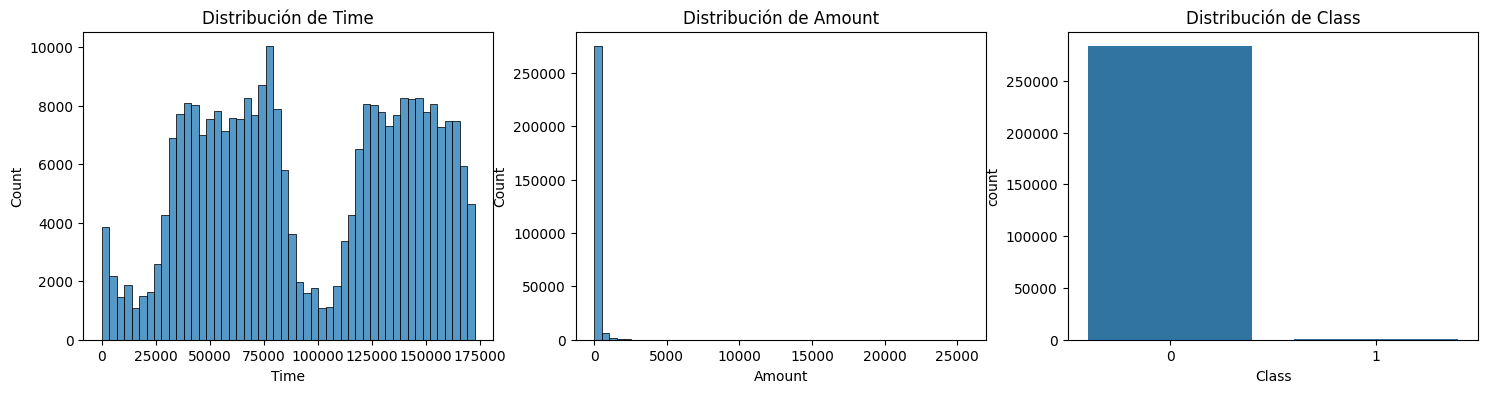

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18,4))

sns.histplot(df['Time'], bins=50, ax=axes[0])
axes[0].set_title('Distribución de Time')

sns.histplot(df['Amount'], bins=50, ax=axes[1])
axes[1].set_title('Distribución de Amount')

sns.countplot(x='Class', data=df, ax=axes[2])
axes[2].set_title('Distribución de Class')

plt.show()

####
*   Amount es altamente asimétrica (cola derecha muy larga)-puede tener posibles outliers
*   Time no sigue una distribución uniforme
*   Class está extremadamente desbalanceada
*   Las variables V1–V28 están estandarizadas (media ≈ 0 pues están en PCA).

In [ ]:
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

outliers_amount = df[
    (df['Amount'] < Q1 - 1.5 * IQR) |
    (df['Amount'] > Q3 + 1.5 * IQR)
]

print(f"Número de posibles outliers en Amount: {len(outliers_amount)}")
print(f"Porcentaje sobre el total: {len(outliers_amount) / len(df) * 100:.2f}%")


##### Según la regla IQR, son valores extremos respecto a la distribución central.

In [ ]:
outliers_amount['Class'].value_counts(normalize=True) * 100

#####
Comparación clave:
*   Fraude total en el dataset ≈ 0.17%
*   Fraude en outliers ≈ 0.27%

Los outliers tienen mayor proporción de fraude que el promedio por lo que debemos conservarlos al poder ser informativos para la detección de fraude

In [ ]:
#visualizamos mejor los outliers mediante un boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Amount'])
plt.title('Boxplot de Amount')
plt.show()

##### Hemos decicido no eliminar los outliers y optar por aplicar una transformación logarítmica para reducir la asimetría y facilitar el análisis, manteniendo la información relevante

In [ ]:
df['Amount_log'] = np.log1p(df['Amount'])

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['Amount_log'], bins=50)
plt.title('Distribución de log(Amount + 1)')
plt.show()

##### La transformación logarítmica de la variable Amount reduce el impacto de los valores extremos. Aunque no genera una distribución normal, facilita el análisis exploratorio y la comparación entre transacciones de distinto importe sin perder información relevante.

### **Análisis Bivariante**

##### **1) Amount_log vs Class**

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Class', y='Amount_log', data=df)
plt.title('Amount (log) vs Class')
plt.show()


##### El análisis bivariante entre Amount_log y la variable objetivo muestra que las transacciones fraudulentas presentan una mediana de importe ligeramente inferior y una mayor dispersión. Esto sugiere que el fraude no se limita a importes elevados y que el importe, de forma aislada, no resulta suficiente para diferenciar ambos tipos de transacciones.

##### **2) Time vs Class**

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Class', y='Time', data=df)
plt.title('Time vs Class')
plt.show()

##### El análisis temporal no revela diferencias significativas entre transacciones fraudulentas y legítimas. El fraude se distribuye de forma relativamente uniforme a lo largo del periodo analizado, lo que indica que la variable Time, de manera aislada, no permite identificar patrones temporales evidentes asociados al fraude.

##### **3) Correlación con Class**

In [ ]:
correlations = df.corr()['Class'].sort_values()

print("Variables más correlacionadas negativamente con Class:")
print(correlations.head(10))

print("\nVariables más correlacionadas positivamente con Class:")
print(correlations.tail(10))

#####
**Correlación negativa (más asociadas a fraude):**
*   V17, V14, V12, V10
*   Valores moderados (≈ −0.3 a −0.2)

**Correlación positiva:**
*   V4, V11, V2
*   Correlaciones más débiles (≈ 0.1–0.15)

##### El análisis de correlación revela que determinadas componentes principales presentan una relación moderada con la variable objetivo, tanto positiva como negativa. No obstante, ninguna variable muestra una correlación fuerte, lo que pone de manifiesto la complejidad del problema y la necesidad de considerar múltiples variables de forma conjunta.

##### **4) Comparación estadística por clase**

In [ ]:
summary_by_class = (
    df
    .groupby('Class')[['Amount', 'Amount_log', 'Time']]
    .agg(['mean', 'median', 'std', 'quantile'])
)

summary_by_class


##### La comparación estadística por clase revela que, aunque las transacciones fraudulentas presentan una media de importe superior, su mediana es significativamente menor que la de las transacciones legítimas. Esto indica una distribución más dispersa del fraude, con presencia de valores extremos, pero con una mayoría de transacciones fraudulentas de importe bajo o moderado. Este comportamiento es coherente con estrategias de fraude orientadas a minimizar la detección.

##### **5) Percentiles de Amount por clase**

In [ ]:
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95]

df.groupby('Class')['Amount'].quantile(percentiles).unstack()


##### El análisis por percentiles muestra que la mayoría de las transacciones fraudulentas se concentran en importes bajos, con valores inferiores a los de las transacciones legítimas en los percentiles centrales. No obstante, en los percentiles superiores el fraude presenta importes significativamente mayores, lo que evidencia la existencia de un reducido número de fraudes de alto impacto económico.

##### **6) Segmentación por cuantiles de Amount**

In [ ]:
df['Amount_bin'] = pd.qcut(df['Amount'], q=5)

df.groupby('Amount_bin')['Class'].mean() * 100


##### La segmentación por cuantiles de importe revela que el fraude no sigue un patrón creciente con el valor de la transacción. Se observa una mayor proporción de fraude tanto en los importes más bajos como en los más elevados, mientras que los rangos intermedios presentan menores tasas de fraude. Este resultado refuerza la complejidad del problema y descarta la existencia de un umbral de importe sencillo para la detección del fraude.

### **Análisis Multivariante**

##### **1) Matriz de Correlación de Variables más Relevantes**

In [ ]:
# Seleccionamos variables más relevantes
# Excluimos la columna 'Amount_bin' que no es numérica y causa el error en la correlación.
top_corr_vars = (
    df.corr(numeric_only=True)['Class'] # Añadimos numeric_only=True
    .abs()
    .sort_values(ascending=False)
    .head(11)        # Class + 10 variables
    .index
)

corr = df[top_corr_vars].corr(numeric_only=True) # También aquí para asegurar que solo se correlacionen columnas numéricas

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=0.5
)

plt.title('Matriz de correlación (variables más relevantes)')
plt.show()

##### Se observan correlaciones moderadas en algunas componentes PCA, pero ninguna relación fuerte. Esto indica que el fraude no puede explicarse mediante una única variable de forma aislada.

##### **2) Correlaciones redundantes entre variables (multicolinealidad)**

In [ ]:
# (Útil para entender si varias variables aportan info similar)
corr_all = df.drop(columns=['Class'], errors='ignore').corr(numeric_only=True).abs()

# Evitar diagonal y duplicados
upper = corr_all.where(np.triu(np.ones(corr_all.shape), k=1).astype(bool))

# Pares con correlación alta (umbral ajustable)
threshold = 0.80
high_corr_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .reset_index()
         .rename(columns={'level_0': 'Var1', 'level_1': 'Var2', 0: 'AbsCorr'})
)

print(f"Pares con correlación absoluta > {threshold}:")
display(high_corr_pairs[high_corr_pairs['AbsCorr'] > threshold].head(15))


##### No se identificaron pares de variables con una correlación lineal elevada (|ρ| > 0.8), lo que indica ausencia de multicolinealidad fuerte en el conjunto de datos. Este resultado es coherente con el uso de componentes principales y sugiere que cada variable aporta información complementaria, reforzando la naturaleza multivariante del problema de detección de fraude.

##### **3) Visualización multivariante en 2D: PCA components (V1 y V2)**

In [ ]:
# Como V1–V28 ya son PCA, es muy útil ver un scatter de 2 componentes
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df.sample(n=min(20000, len(df)), random_state=42),  # muestreo para velocidad
    x='V1',
    y='V2',
    hue='Class',
    alpha=0.6
)
plt.title('Scatter V1 vs V2 coloreado por Class (muestra)')
plt.show()


##### El gráfico representa la relación conjunta entre las dos primeras componentes principales. Las transacciones fraudulentas aparecen mezcladas con las legítimas, sin una separación clara. Esto sugiere que la combinación de dos variables no es suficiente para identificar el fraude

##### **4) Visualización multivariante en 3D: V1, V2, V3**

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

sample_df = df.sample(n=min(20000, len(df)), random_state=42)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    sample_df['V1'], sample_df['V2'], sample_df['V3'],
    c=sample_df['Class'],
    alpha=0.5,
    s=8
)

ax.set_xlabel('V1')
ax.set_ylabel('V2')
ax.set_zlabel('V3')
ax.set_title('Scatter 3D (V1, V2, V3) coloreado por Class (muestra)')
plt.show()

##### La visualización en tres dimensiones combina varias componentes principales para explorar patrones complejos. Aun considerando tres variables, no se observa una separación clara entre fraude y no fraude. Esto confirma la complejidad del problema y la necesidad de analizar múltiples variables de forma conjunta.

##### **5) Pairplot solo con variables más relacionadas con Class**

In [ ]:
# (Muy útil, pero limitado a pocas variables para que sea legible)
# Seleccionamos las 5 variables más relacionadas con 'Class' (incluyendo 'Class' misma)
top_for_pairplot_cols = (
    df.corr(numeric_only=True)['Class']
      .abs()
      .sort_values(ascending=False)
      .head(5)
      .index
).tolist() # Convertimos el Index a lista de nombres de columnas

# Tomamos una muestra para que el pairplot sea legible y rápido
sampled_df = df[top_for_pairplot_cols].sample(n=min(5000, len(df)), random_state=42)

# Creamos el pairplot
sns.pairplot(
    data=sampled_df,
    hue='Class',
    corner=True,
    plot_kws={'alpha': 0.6, 's': 10}
)
plt.suptitle('Pairplot (Class + variables más relacionadas) - muestra', y=1.02)
plt.show()

##### Este gráfico permite analizar simultáneamente varias variables relevantes y sus relaciones entre pares. Aunque se aprecian ciertos patrones, las clases siguen solapándose ampliamente. Refuerza la idea de que el fraude requiere un enfoque multivariante.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Class', 'Amount_bin']) # Drop 'Amount_bin' column
y = df['Class']

# Escalado
X_scaled = StandardScaler().fit_transform(X)

# PCA a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y.values

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Class',
    alpha=0.6
)
plt.title('Proyección PCA (2 componentes)')
plt.show()

##### Este gráfico muestra una proyección del dataset completo en dos dimensiones mediante PCA. Las transacciones fraudulentas se encuentran mezcladas con las legítimas, sin una separación clara entre clases. Esto indica que, incluso considerando la información conjunta de todas las variables, el fraude no es fácilmente separable en un espacio de baja dimensión.

##### **6) Distribución acumulada de Amount_log**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

for c, label in [(0, 'No Fraude'), (1, 'Fraude')]:
    data = np.sort(df[df['Class'] == c]['Amount_log'])
    y = np.arange(len(data)) / len(data)
    plt.plot(data, y, label=label)

plt.xlabel('Amount_log')
plt.ylabel('Proporción acumulada')
plt.title('Distribución acumulada de Amount_log por clase')
plt.legend()
plt.show()


##### La distribución acumulada de Amount_log muestra diferencias en el comportamiento de las transacciones fraudulentas y legítimas. Una mayor proporción de fraudes se concentra en importes bajos, mientras que en los rangos medios y altos las curvas se aproximan, indicando la ausencia de un umbral de importe claro para la detección del fraude.

### **Tabla Resumen Conclusiones EDA**

In [ ]:
insights = pd.DataFrame({
    'Insight': [
        'Porcentaje de fraude total',
        'Mediana Amount No Fraude',
        'Mediana Amount Fraude',
        'Porcentaje de outliers en Amount',
        'Variables más correlacionadas con Class'
    ],
    'Valor': [
        f"{df['Class'].mean()*100:.2f}%",
        df[df['Class']==0]['Amount'].median(),
        df[df['Class']==1]['Amount'].median(),
        "11.17%",
        "V17, V14, V12, V10"
    ]
})

insights